#  Fake News Detector with LSTM  

1.  Preprocess data
2.  one_hot encoding
3.  create LSTM model
4.  observe the alteration in shape, flattening and then re-shaping - changes from embedding to flattening - to - dense layer <br>
5. Observe the total weight matrix size of the LSTM - mathematical verification

##  LSTM
 'fit' or train on some training data; joins these two steps and is used for the initial fitting of parameters on the training set 𝑥, while also returning the transformed 𝑥′. Internally, the transformer object just calls first fit() and then transform() on the same data.<br>In the output, you will see (20000, 5) which means that each of the document has 5 columns where each column corresponds to the probability value of a particular topic.

In [ ]:
import re
import pandas as pd
import nltk
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Embedding, Dense, LSTM, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

# Loading the data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip fakenews.zip

Archive:  fakenews.zip
  inflating: train.csv               


In [ ]:
df = pd.read_csv("train.csv")
df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


# Performing some basic EDA

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20800 non-null  int64 
 1   title   20242 non-null  object
 2   author  18843 non-null  object
 3   text    20761 non-null  object
 4   label   20800 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 812.6+ KB


In [ ]:
df.isnull().sum()

id        0
title     0
author    0
text      0
label     0
dtype: int64

In [ ]:
# remove all the rows having null values
df.dropna(inplace=True)

In [ ]:
df

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1
...,...,...,...,...,...
20795,20795,Rapper T.I.: Trump a ’Poster Child For White S...,Jerome Hudson,Rapper T. I. unloaded on black celebrities who...,0
20796,20796,"N.F.L. Playoffs: Schedule, Matchups and Odds -...",Benjamin Hoffman,When the Green Bay Packers lost to the Washing...,0
20797,20797,Macy’s Is Said to Receive Takeover Approach by...,Michael J. de la Merced and Rachel Abrams,The Macy’s of today grew from the union of sev...,0
20798,20798,"NATO, Russia To Hold Parallel Exercises In Bal...",Alex Ansary,"NATO, Russia To Hold Parallel Exercises In Bal...",1


In [ ]:
df.isnull().sum()

id        0
title     0
author    0
text      0
label     0
dtype: int64

In [ ]:
x = df[['title', 'author', 'text']]
y = df['label']

In [ ]:
x.reset_index()

,index,title,author,text
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ..."
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...
...,...,...,...,...
18280,20795,Rapper T.I.: Trump a ’Poster Child For White S...,Jerome Hudson,Rapper T. I. unloaded on black celebrities who...
18281,20796,"N.F.L. Playoffs: Schedule, Matchups and Odds -...",Benjamin Hoffman,When the Green Bay Packers lost to the Washing...
18282,20797,Macy’s Is Said to Receive Takeover Approach by...,Michael J. de la Merced and Rachel Abrams,The Macy’s of today grew from the union of sev...
18283,20798,"NATO, Russia To Hold Parallel Exercises In Bal...",Alex Ansary,"NATO, Russia To Hold Parallel Exercises In Bal..."


In [ ]:
y=y.reset_index()

In [ ]:
y=y['label']

In [ ]:
y

0        1
1        0
2        1
3        1
4        1
        ..
18280    0
18281    0
18282    0
18283    1
18284    1
Name: label, Length: 18285, dtype: int64

In [ ]:
x['title'][0]

'House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It'

In [ ]:
print(x['text'][0])

House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It By Darrell Lucus on October 30, 2016 Subscribe Jason Chaffetz on the stump in American Fork, Utah ( image courtesy Michael Jolley, available under a Creative Commons-BY license) 
With apologies to Keith Olbermann, there is no doubt who the Worst Person in The World is this week–FBI Director James Comey. But according to a House Democratic aide, it looks like we also know who the second-worst person is as well. It turns out that when Comey sent his now-infamous letter announcing that the FBI was looking into emails that may be related to Hillary Clinton’s email server, the ranking Democrats on the relevant committees didn’t hear about it from Comey. They found out via a tweet from one of the Republican committee chairmen. 
As we now know, Comey notified the Republican chairmen and Democratic ranking members of the House Intelligence, Judiciary, and Oversight committees that his agency was reviewing emails 

# Extracting Titles and Classifying

In [ ]:
x_t=x['title']

In [ ]:
x_t=x_t.reset_index()

In [ ]:
x_t=x_t['title']

In [ ]:
len(x_t)

18285

In [ ]:
x_t

0        House Dem Aide: We Didn’t Even See Comey’s Let...
1        FLYNN: Hillary Clinton, Big Woman on Campus - ...
2                        Why the Truth Might Get You Fired
3        15 Civilians Killed In Single US Airstrike Hav...
4        Iranian woman jailed for fictional unpublished...
                               ...                        
18280    Rapper T.I.: Trump a ’Poster Child For White S...
18281    N.F.L. Playoffs: Schedule, Matchups and Odds -...
18282    Macy’s Is Said to Receive Takeover Approach by...
18283    NATO, Russia To Hold Parallel Exercises In Bal...
18284                            What Keeps the F-35 Alive
Name: title, Length: 18285, dtype: object

In [ ]:
ws = WordNetLemmatizer()
list_titles = []
for i in range(0, len(x_t)):
  headline = re.sub('[^a-zA-Z]', ' ', x_t[i])
  #matching the text string for any lower case letter or uppercase
  #when the ^ is on the inside of [], itmatches any character that does not appear inside []
  #when ^ is on the outside of the []; i tmatches the beginning of the line/string - title
  headline = headline.lower()
  headline = headline.split()
  headline = [ws.lemmatize(word) for word in headline if word not in stopwords.words("english")]
  headline = ' '.join(headline)
  list_titles.append(headline) #adds a single item to the existing list

In [ ]:
list_titles

['house dem aide even see comey letter jason chaffetz tweeted',
 'flynn hillary clinton big woman campus breitbart',
 'truth might get fired',
 'civilian killed single u airstrike identified',
 'iranian woman jailed fictional unpublished story woman stoned death adultery',
 'jackie mason hollywood would love trump bombed north korea lack trans bathroom exclusive video breitbart',
 'beno hamon win french socialist party presidential nomination new york time',
 'back channel plan ukraine russia courtesy trump associate new york time',
 'obama organizing action partner soros linked indivisible disrupt trump agenda',
 'bbc comedy sketch real housewife isi cause outrage',
 'russian researcher discover secret nazi military base treasure hunter arctic photo',
 'u official see link trump russia',
 'yes paid government troll social medium blog forum website',
 'major league soccer argentine find home success new york time',
 'well fargo chief abruptly step new york time',
 'anonymous donor pay 


Keras provide the function one_hot to efficiently encode each word in the titles as an interger.
This must be done prior to Word Embedding
Index of words located in the Dictionary


In [ ]:
vocab=10000
hot_title = [one_hot(i, vocab) for i in list_titles]
hot_title[:4]

[[7971, 1125, 8570, 494, 8423, 2977, 1621, 2506, 8672, 4826],
 [7117, 8425, 4336, 9026, 9027, 455, 738],
 [5792, 4122, 3401, 1972],
 [6686, 7764, 5406, 135, 4096, 4701]]

In [ ]:
longest = [len(i) for i in hot_title]
max(longest)

47

In [ ]:
max_length = 50
embed_input = pad_sequences(hot_title, maxlen = max_length, padding='pre')
print(embed_input)

[[   0    0    0 ... 2506 8672 4826]
 [   0    0    0 ... 9027  455  738]
 [   0    0    0 ... 4122 3401 1972]
 ...
 [   0    0    0 ... 6015 7003  461]
 [   0    0    0 ... 7108 9946  876]
 [   0    0    0 ... 7120 9632 3516]]


# Modelling the data

Arguments:

sequences:List of lists where each element is a sequence

maxlen:int, maximum length of all sequences

dtype:type of the output sequences

padding 'pre' or 'post', pad either before or after each sequence.

Input shape: 2D tensor with shape: (batch_size, input_length).

In [ ]:
model = Sequential() #creating the sequential model incrementally vi the add() method
model.add(Embedding(input_dim=vocab, output_dim= 40, input_length=50))
model.add(LSTM(150))
model.add(Dense(1, activation='sigmoid'))#sigmoid returns a value close to zero
#config the model with losses and metrics - compile()
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 40)            400000    
                                                                 
 lstm (LSTM)                 (None, 150)               114600    
                                                                 
 dense (Dense)               (None, 1)                 151       
                                                                 
Total params: 514,751
Trainable params: 514,751
Non-trainable params: 0
_________________________________________________________________
None


sequence()a plain stack of layers where each layer has exactly one input tensor and one output tensor
create a Sequential model incrementally via the add() method
the input of the LSTM is always a 3D array (batch_size, time_steps, units)
The output of the LSTM could be a 2D array or 3D array depending upon the return_sequences argument. If return_sequence is False, the output is a 2D array. (batch_size, units) If return_sequence is True, the output is a 3D array. (batch_size, time_steps, units)
in this case; the return_sequence is false - this is the default, therefore - 2D LSTM output

3D tensor with shape: (batch_size, input_length, output_dim). alteration in shape, flattening and then re-shaping

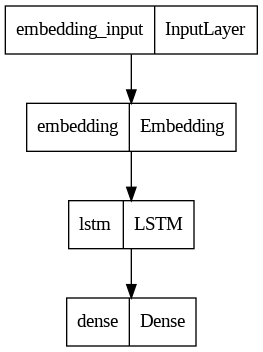

In [ ]:
# Describe the model
plot_model(model)

In [ ]:
embed_input.shape

(18285, 50)

In [ ]:
y.shape

(18285,)

In [ ]:
x_final = np.array(embed_input)
y_final = np.array(y)
x_final.shape, y_final.shape

((18285, 50), (18285,))

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_final, y_final, test_size=0.33, random_state=42)

In [ ]:
# Fitting the model
model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10, batch_size=64)

Epoch 1/10
192/192 [==============================] - 27s 101ms/step - loss: 0.3217 - accuracy: 0.8525 - val_loss: 0.1900 - val_accuracy: 0.9203
Epoch 2/10
192/192 [==============================] - 4s 23ms/step - loss: 0.1197 - accuracy: 0.9514 - val_loss: 0.2004 - val_accuracy: 0.9251
Epoch 3/10
192/192 [==============================] - 4s 18ms/step - loss: 0.0613 - accuracy: 0.9771 - val_loss: 0.2279 - val_accuracy: 0.9135
Epoch 4/10
192/192 [==============================] - 3s 15ms/step - loss: 0.0264 - accuracy: 0.9918 - val_loss: 0.3528 - val_accuracy: 0.9178
Epoch 5/10
192/192 [==============================] - 2s 11ms/step - loss: 0.0155 - accuracy: 0.9949 - val_loss: 0.3391 - val_accuracy: 0.9143
Epoch 6/10
192/192 [==============================] - 2s 11ms/step - loss: 0.0063 - accuracy: 0.9984 - val_loss: 0.5094 - val_accuracy: 0.9060
Epoch 7/10
192/192 [==============================] - 4s 20ms/step - loss: 0.0024 - accuracy: 0.9995 - val_loss: 0.4972 - val_accuracy: 0.91

Describe performance of classificaiton model
tweak to make sure that 'acc' and 'val_acc' and final 'accuracy' are more closer to each other.

It is normal for validation accuracy to be lower than accuracy. But ideally, these values should be kept similar range. If validation accuracy is much lower than accuracy, be cautious of over fitting
acc' refers to accuracy of what was trained against.


'val_acc' refers to validation set. Note that val_acc refers to a set of samples that was not shown to the network during training and hence refers to how much your model works in general for cases outside the training set.

In [ ]:
predict_x=model.predict(x_test)
classes_x=np.argmax(predict_x,axis=1)

189/189 [==============================] - 1s 3ms/step


In [ ]:
classes_x

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
y_test.shape

(6035,)

In [ ]:
classes_x.shape

(6035,)

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, classes_x)

0.5665285832642917

In [ ]:
 from sklearn.metrics import confusion_matrix
 confusion_matrix(y_test, classes_x)

array([[3419,    0],
       [2616,    0]])

In [ ]:
model.evaluate(embed_input, y)

572/572 [==============================] - 4s 5ms/step - loss: 0.2190 - accuracy: 0.9718


[0.2190079540014267, 0.9718348383903503]

In [ ]:
score = model.evaluate(x_test, y_test, verbose = 0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.6814343929290771
Test accuracy: 0.9146644473075867


# Checking with Text

In [ ]:
text=x['text']

In [ ]:
text=text.reset_index()

In [ ]:
text=text['text']

In [ ]:
text

0        House Dem Aide: We Didn’t Even See Comey’s Let...
1        Ever get the feeling your life circles the rou...
2        Why the Truth Might Get You Fired October 29, ...
3        Videos 15 Civilians Killed In Single US Airstr...
4        Print \nAn Iranian woman has been sentenced to...
                               ...                        
18280    Rapper T. I. unloaded on black celebrities who...
18281    When the Green Bay Packers lost to the Washing...
18282    The Macy’s of today grew from the union of sev...
18283    NATO, Russia To Hold Parallel Exercises In Bal...
18284      David Swanson is an author, activist, journa...
Name: text, Length: 18285, dtype: object

In [ ]:
y

0        1
1        0
2        1
3        1
4        1
        ..
18280    0
18281    0
18282    0
18283    1
18284    1
Name: label, Length: 18285, dtype: int64

In [ ]:
ws = WordNetLemmatizer()
list_text = []
for i in range(0, len(text)):
  headline = re.sub('[^a-zA-Z]', ' ', text[i])
  #matching the text string for any lower case letter or uppercase
  #when the ^ is on the inside of [], itmatches any character that does not appear inside []
  #when ^ is on the outside of the []; i tmatches the beginning of the line/string - title
  headline = headline.lower()
  headline = headline.split()
  headline = [ws.lemmatize(word) for word in headline if word not in stopwords.words("english")]
  headline = ' '.join(headline)
  list_text.append(headline) #adds a single item to the existing list

In [ ]:
list_text

In [ ]:
vocab=20000
ohe_text = [one_hot(i, vocab) for i in list_text]
ohe_text[:4]

In [ ]:
longest = [len(i) for i in ohe_text]
max(longest)

In [ ]:
max_length = max(longest)
embed_input = pad_sequences(ohe_text, maxlen = max_length, padding='pre')
print(embed_input)

In [ ]:
model = Sequential() #creating the sequential model incrementally vi the add() method
model.add(Embedding(input_dim=vocab, output_dim= 40, input_length=max_length))
model.add(LSTM(150))
model.add(Dense(1, activation='sigmoid'))#sigmoid returns a value close to zero
#config the model with losses and metrics - compile()
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])
print(model.summary())

In [ ]:
x_final = np.array(embed_input)
y_final = np.array(y)
x_final.shape, y_final.shape

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_final, y_final, test_size=0.33, random_state=42)

In [ ]:
model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10, batch_size=64)

In [ ]:
predict_x=model.predict(x_test)
classes_x=np.argmax(predict_x,axis=1)

In [ ]:
accuracy_score(y_test, classes_x)

In [ ]:
confusion_matrix(y_test, classes_x)